## Deep Deterministic Policy Gradient (DDPG)

In [58]:
try:
    import gymnasium as gym
    from gymnasium.spaces import Box, Discrete
    from gymnasium import spaces
except ImportError:
    %pip install gymnasium
    import gymnasium as gym
    from gymnasium.spaces import Box, Discrete
    from gymnasium import spaces

try:
    from mpi4py import MPI
except ImportError:
    %pip install mpi4py
    from mpi4py import MPI

try:
    import torchviz
except ImportError:
    %pip install torchviz
    import torchviz
# Standard library imports
import os
import time
from copy import deepcopy

import matplotlib.pyplot as plt
# Third-party imports
import numpy as np
import pandas as pd
# PyTorch imports
import torch
import torch.nn as nn
from torch.optim import Adam
import subprocess

In [59]:
import logging

logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [60]:
if not os.path.isfile("trajectory.csv"):
    !wget https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/SAC/trajectory.csv

In [61]:
if not os.path.isdir('utils'):
    %mkdir utils
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/logx.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/mpi_tools.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/serialization_utils.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/run_utils.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/user_config.py
# spinning up utilities
# import utils
from utils.logx import EpochLogger
from utils.logx import colorize
from utils.run_utils import setup_logger_kwargs

In [84]:
# download ddpg with no dg model
if not os.path.isdir('model'):
    %mkdir model
    !wget -P model https://github.com/alibaniasad1999/master-thesis/raw/main/Code/Python/TBP/DDPG/model/actor_cuda.pth
    !wget -P model https://github.com/alibaniasad1999/master-thesis/raw/main/Code/Python/TBP/DDPG/model/q_cuda.pth

--2025-03-29 12:01:03--  https://github.com/alibaniasad1999/master-thesis/raw/main/Code/Python/TBP/DDPG/model/actor_cuda.pth
Resolving github.com (github.com)... 198.18.0.115
Connecting to github.com (github.com)|198.18.0.115|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/DDPG/model/actor_cuda.pth [following]
--2025-03-29 12:01:04--  https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/DDPG/model/actor_cuda.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 198.18.0.121
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|198.18.0.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7836 (7.7K) [application/octet-stream]
Saving to: ‘model/actor_cuda.pth’

actor_cuda.pth      100%[===================>]   7.65K  --.-KB/s    in 0.03s   

2025-03-29 12:01:05 (294 KB/s) - ‘model/actor_

In [85]:
# Define the model directory and file URLs
model_dir = 'model'
urls = [
    'https://github.com/alibaniasad1999/master-thesis/raw/main/Code/Python/TBP/DDPG/model/actor_cuda.pth',
    'https://github.com/alibaniasad1999/master-thesis/raw/main/Code/Python/TBP/DDPG/model/q_cuda.pth'
]

# Check if the directory exists
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
    print(f"Directory '{model_dir}' created.")
else:
    # Check if the directory is empty
    if not os.listdir(model_dir):
        print(f"Directory '{model_dir}' exists but is empty.")
    else:
        print(f"Directory '{model_dir}' already exists and is not empty.")

# Download the files
for url in urls:
    filename = os.path.join(model_dir, os.path.basename(url))
    if not os.path.isfile(filename):
        print(f"Downloading {url} to {filename}...")
        subprocess.run(['wget', '-P', model_dir, url])
    else:
        print(f"File {filename} already exists; skipping download.")


Directory 'model' created.


--2025-03-29 12:03:07--  https://github.com/alibaniasad1999/master-thesis/raw/main/Code/Python/TBP/DDPG/model/actor_cuda.pth
Resolving github.com (github.com)... 198.18.0.115
Connecting to github.com (github.com)|198.18.0.115|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/DDPG/model/actor_cuda.pth [following]
--2025-03-29 12:03:08--  https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/DDPG/model/actor_cuda.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 198.18.0.121
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|198.18.0.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7836 (7.7K) [application/octet-stream]
Saving to: ‘model/actor_cuda.pth’

     0K .......                                               100%  249K=0.03s

2025-03-29 12:03:09 (249 KB/s) - ‘model/actor_c

HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/DDPG/model/q_cuda.pth [following]
--2025-03-29 12:03:10--  https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/DDPG/model/q_cuda.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 198.18.0.121
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|198.18.0.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7604 (7.4K) [application/octet-stream]
Saving to: ‘model/q_cuda.pth’

     0K .......                                               100% 3.78M=0.002s

2025-03-29 12:03:11 (3.78 MB/s) - ‘model/q_cuda.pth’ saved [7604/7604]



# DDPG Core

In [62]:
def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)


def mlp(sizes, activation, output_activation=nn.Identity, device=torch.device("cpu")):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act()]
    return nn.Sequential(*layers).to(device)


def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])


class MLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit, device=torch.device("cpu")):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Tanh, device)
        self.act_limit = act_limit

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.act_limit * self.pi(obs)


class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, device=torch.device("cpu")):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation, device=device)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1)  # Critical to ensure q has right shape.


class MLPActorCritic(nn.Module):

    def __init__(self, observation_space, action_space, hidden_sizes=(256, 256),
                 activation=nn.Tanh, device=torch.device("cpu")):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit, device).to(device)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation, device).to(device)

    def act(self, obs):
        with torch.no_grad():
            return self.pi(obs).cpu().numpy()

In [63]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents.
    """

    def __init__(self, obs_dim, act_dim, act_2_dim, size, device=torch.device("cpu")):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.act_2_buf = np.zeros(combined_shape(size, act_2_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, act_2, rew, next_obs, done):
        # print(obs)
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.act_2_buf[self.ptr] = act_2
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     act_2=self.act_2_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32, device=device) for k, v in batch.items()}

In [64]:
class DG_DDPG:
    def __init__(self, env_fn, actor_critic, ac_kwargs_, seed_=0,
                 steps_per_epoch=30000, epochs_=100, replay_size=int(1e6),
                 gamma_=0.99, polyak=0.995, pi_lr=1e-3, q_lr=1e-3, first_player_epoch=50,
                 # after how many epoch first actor should learn new
                 batch_size=1024, start_steps=5000, update_after=1000,
                 update_every=2000, act_noise=0.1, num_test_episodes=10,
                 max_ep_len=6000, save_freq=1, logger_kwargs_=None, device=torch.device("cpu")):

        torch.manual_seed(seed_)
        np.random.seed(seed_)

        self.env, self.test_env = env_fn(), env_fn()
        obs_dim = self.env.observation_space.shape
        act_dim = self.env.action_space.shape[0]
        self.act_limit = self.env.action_space.high[0]

        self.ac = actor_critic(self.env.observation_space, self.env.action_space, **ac_kwargs_, device=device)
        self.ac_targ = deepcopy(self.ac)
        for p in self.ac_targ.parameters():
            p.requires_grad = False

        # second player
        self.ac_2 = actor_critic(self.env.observation_space, self.env.action_space, **ac_kwargs_, device=device)
        self.ac_2_targ = deepcopy(self.ac_2)
        for p in self.ac_2_targ.parameters():
            p.requires_grad = False

        self.replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, act_2_dim=act_dim, size=replay_size,
                                          device=device)
        self.gamma = gamma_
        self.polyak = polyak
        self.pi_optimizer = Adam(self.ac.pi.parameters(), lr=pi_lr)
        self.q_optimizer = Adam(self.ac.q.parameters(), lr=q_lr)
        self.q_optimizer_2 = Adam(self.ac_2.q.parameters(), lr=q_lr)
        self.pi_optimizer_2 = Adam(self.ac_2.pi.parameters(), lr=pi_lr)
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs_
        self.start_steps = start_steps
        self.first_player_epoch = first_player_epoch
        self.update_after = update_after
        self.update_every = update_every
        self.act_noise = act_noise
        self.num_test_episodes = num_test_episodes
        self.max_ep_len = max_ep_len
        self.save_freq = save_freq
        self.logger = EpochLogger(**logger_kwargs_)
        self.logger.save_config(locals())
        self.logger.setup_pytorch_saver(self.ac)
        # Count variables (protip: try to get a feel for how different size networks behave!)
        var_counts = tuple(count_vars(module) for module in [self.ac.pi, self.ac.q])
        self.logger.log('\nNumber of parameters: \t pi: %d, \t q: %d\n' % var_counts)

    def compute_loss_q(self, data_):
        o, a, r, o2, d = data_['obs'], data_['act'], data_['rew'], data_['obs2'], data_['done']
        # print(o)
        q = self.ac.q(o, a)
        # print('after o')
        with torch.no_grad():
            q_pi_targ = self.ac_targ.q(o2, self.ac_targ.pi(o2))
            backup = r + self.gamma * (1 - d) * q_pi_targ
        loss_q = ((q - backup) ** 2).mean()

        # Useful info for logging
        loss_info = dict(QVals=q.detach().cpu().numpy())

        return loss_q, loss_info

    def compute_loss_q_2(self, data_):
        o, a, r, o2, d = data_['obs'], data_['act_2'], data_['rew'], data_['obs2'], data_['done']
        # print(o)
        q = self.ac_2.q(o, a)
        # print('after o')
        # zero sum game
        r = -r
        with torch.no_grad():
            q_pi_targ = self.ac_2_targ.q(o2, self.ac_2_targ.pi(o2))
            backup = r + self.gamma * (1 - d) * q_pi_targ
        loss_q = ((q - backup) ** 2).mean()

        # Useful info for logging
        # print('Q is here')
        loss_info = dict(QVals_2=q.detach().cpu().numpy())
        return loss_q, loss_info

    def compute_loss_pi(self, data_):
        o = data_['obs']
        q_pi = self.ac.q(o, self.ac.pi(o))
        return -q_pi.mean()

    def compute_loss_pi_2(self, data_):
        o = data_['obs']
        q_pi = self.ac_2.q(o, self.ac_2.pi(o))
        return -q_pi.mean()

    def update(self, data_):
        # Update Q-network for ac
        self.q_optimizer.zero_grad()
        loss_q, loss_info = self.compute_loss_q(data_)
        loss_q.backward()
        self.q_optimizer.step()

        # Freeze Q-network for policy update
        for p in self.ac.q.parameters():
            p.requires_grad = False

        # Update policy network for ac
        self.pi_optimizer.zero_grad()
        loss_pi = self.compute_loss_pi(data_)
        loss_pi.backward()
        self.pi_optimizer.step()

        # Unfreeze Q-network
        for p in self.ac.q.parameters():
            p.requires_grad = True

        # Log losses
        self.logger.store(LossQ=loss_q.item(), LossPi=loss_pi.item(), **loss_info)

        # Update target networks
        with torch.no_grad():
            for p, p_targ in zip(self.ac.parameters(), self.ac_targ.parameters()):
                p_targ.data.mul_(self.polyak)
                p_targ.data.add_((1 - self.polyak) * p.data)




    def update_2(self, data_):
        # Update Q-network for ac_2
        self.q_optimizer_2.zero_grad()
        loss_q_2, loss_info_2 = self.compute_loss_q_2(data_)
        loss_q_2.backward()
        self.q_optimizer_2.step()

        # Freeze Q-network for policy update
        for p in self.ac_2.q.parameters():
            p.requires_grad = False

        # Update policy network for ac_2
        self.pi_optimizer_2.zero_grad()
        loss_pi_2 = self.compute_loss_pi_2(data_)
        loss_pi_2.backward()
        self.pi_optimizer_2.step()

        # Unfreeze Q-network
        for p in self.ac_2.q.parameters():
            p.requires_grad = True

        # Log losses
        # print(loss_pi_2.item())
        self.logger.store(LossQ_2=loss_q_2.item(), LossPi_2=loss_pi_2.item(), **loss_info_2)

        # Update target networks
        with torch.no_grad():
            for p, p_targ in zip(self.ac_2.parameters(), self.ac_2_targ.parameters()):
                p_targ.data.mul_(self.polyak)
                p_targ.data.add_((1 - self.polyak) * p.data)

    def get_action(self, o, noise_scale):
            a = self.ac.act(torch.as_tensor(o, dtype=torch.float32, device=device))
            a += noise_scale * np.random.randn(self.env.action_space.shape[0])
            return np.clip(a, -self.act_limit, self.act_limit)

    def get_action_2(self, o, noise_scale):
            a = self.ac_2.act(torch.as_tensor(o, dtype=torch.float32, device=device))
            a += noise_scale * np.random.randn(self.env.action_space.shape[0])
            return np.clip(a, -self.act_limit, self.act_limit)

    def train(self, epochs_=None):
        if epochs_ is None:
            epochs_ = self.epochs
        total_steps = self.steps_per_epoch * epochs_
        first_player_start_time = self.steps_per_epoch * self.first_player_epoch
        start_time = time.time()
        o, _ = self.env.reset()
        ep_ret, ep_len = 0, 0

        for t in range(total_steps):
            a = self.get_action(o, self.act_noise)
            if t > self.start_steps:
                a_2 = self.get_action_2(o, self.act_noise)
            else:
                a_2 = self.env.action_space.sample()
                # print(a)

            o2, r, d, _, _ = self.env.step(a, a_2)
            self.replay_buffer.store(o, a, a_2, r, o2, d)
            reward_array.append(r)
            o = o2
            ep_ret += r
            ep_len += 1

            if d or (ep_len == self.max_ep_len):
                # print('done')
                self.logger.store(EpRet=ep_ret, EpLen=ep_len)
                o, _ = self.env.reset()
                ep_ret, ep_len = 0, 0

            if t >= self.update_after and t % self.update_every == 0 and t > first_player_start_time:
                print(colorize("updating  🥰☺️", 'blue', bold=True))
                for _ in range(500):
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    self.update(batch)

            if t >= self.update_after and t % self.update_every == 0:
                print(colorize("updating second 🥰☺️", 'blue', bold=True))
                for _ in range(500):
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    self.update_2(batch)

            if (t + 1) % self.steps_per_epoch == 0:
                epoch = (t + 1) // self.steps_per_epoch
                print(f"Epoch {epoch} completed in {time.time() - start_time:.2f} sec")
                # if self.logger:
                #     self.logger.log_tabular('Epoch', epoch)
                #     self.logger.dump_tabular()

                if epoch % self.save_freq == 0 and self.logger:
                    self.logger.save_state({'env': self.env}, None)

                # Log info about epoch
                self.logger.log_tabular('Epoch', epoch)
                self.logger.log_tabular('EpRet', with_min_and_max=True)
                # try:
                self.logger.log_tabular('EpLen', average_only=True)
                # except:
                # self.logger.log_tabular('EpLen', with_min_and_max=True)

                if t > first_player_start_time:
                    self.logger.log_tabular('QVals', with_min_and_max=True)
                    self.logger.log_tabular('LossPi', average_only=True)
                    self.logger.log_tabular('LossQ', average_only=True)



                self.logger.log_tabular('TotalEnvInteracts', t)

                self.logger.log_tabular('QVals_2', with_min_and_max=True)

                self.logger.log_tabular('LossPi_2', average_only=True)

                self.logger.log_tabular('LossQ_2', average_only=True)
                self.logger.log_tabular('Time', time.time() - start_time)
                self.logger.dump_tabular()
                self.test()

    def test(self, fun_mode=False, save_data=False, second_player=False):
        o, _ = self.env.reset()
        state_array = []
        action_array = []
        action_2_array = []
        noise = 0
        while True:
            a = self.get_action(o, noise)
            a_2 = self.get_action_2(o, noise)
            action_array.append(a)
            action_2_array.append(a_2)
            o, _, d, _, position = self.env.step(a, a_2)
            state_array.append(position)
            if d:
                break
        dt = self.env.dt
        time = np.arange(0, len(state_array) * dt, dt)
        state_array = np.array(state_array)
        action_array = np.array(action_array)
        action_2_array = np.array(action_2_array)
        # save trajectory and actions to csv
        if not os.path.exists('results/') and save_data:
            os.makedirs('results/')

        # numpy to pandas with header
        state_df = pd.DataFrame(state_array, columns=['x', 'y', 'xdot', 'ydot'])
        action_df = pd.DataFrame(action_array, columns=['ax', 'ay'])
        action_2_df = pd.DataFrame(action_2_array, columns=['ax', 'ay'])

        # save to csv
        if save_data:
            state_df.to_csv('results/state.csv', index=False)
            action_df.to_csv('results/action.csv', index=False)
            print(colorize("Data saved to results folder 😜", 'green', bold=True))

        df = pd.read_csv('trajectory.csv')
        # df to numpy array
        data = df.to_numpy()
        print(data.shape)
        trajectory = np.delete(data, 2, 1)
        trajectory = np.delete(trajectory, -1, 1)

        if fun_mode:
            # Use XKCD style for hand-drawn look
            with plt.xkcd():
                plt.plot(state_array[:, 0], state_array[:, 1], label='State')
                plt.plot(trajectory[:, 0], trajectory[:, 1], label='Trajectory')
                plt.legend()
                plt.show()
            with plt.xkcd():
                plt.plot(time, action_array)
                plt.xlabel("Time (sec)")
                plt.ylabel("action (N)")
                plt.show()
        else:
            plt.plot(state_array[:, 0], state_array[:, 1], label='State')
            plt.plot(trajectory[:, 0], trajectory[:, 1], label='Trajectory')
            plt.legend()
            # axis equalor
            plt.axis('equal')

            plt.show()

            plt.plot(action_array)
            plt.xlabel("Time (sec)")
            plt.ylabel("action (N)")
            plt.show()

            plt.plot(action_2_array)
            plt.xlabel("Time (sec)")
            plt.ylabel("action (N)")
            plt.show()

    # save actor critic
    def save(self, filepath='model/'):
        if not os.path.isdir(filepath):
            os.mkdir(filepath)
        # Check the device of the model
        if device == 'cuda':
            torch.save(self.ac.pi.state_dict(), filepath + 'actor_cuda.pth')
            torch.save(self.ac.q.state_dict(), filepath + 'q_cuda.pth')
        else:
            torch.save(self.ac.pi.state_dict(), filepath + 'actor_cpu.pth')
            torch.save(self.ac.q.state_dict(), filepath + 'q_cpu.pth')
        print(colorize(f"Model saved successfully! 🥰😎", 'blue', bold=True))

    def save_2(self, filepath='model/'):
        if not os.path.isdir(filepath):
            os.mkdir(filepath)
        if device == 'cuda':
            torch.save(self.ac_2.pi.state_dict(), filepath + 'actor_2_cuda.pth')
            torch.save(self.ac_2.q.state_dict(), filepath + 'q_2_cuda.pth')
        else:
            torch.save(self.ac_2.pi.state_dict(), filepath + 'actor_2_cpu.pth')
            torch.save(self.ac_2.q.state_dict(), filepath + 'q_2_cpu.pth')

    # load actor critic
    def load(self, filepath='model/', load_device=torch.device("cpu"), from_device_to_load='cpu'):
        # self.start_steps = 0 # does not distarct the loaded model
        # check if the model is available
        if os.path.isfile(filepath + 'actor_cpu.pth') or os.path.isfile(filepath + 'actor_cuda.pth'):
            # Check the device of the model
            if from_device_to_load == 'cpu':
                actor_file = 'actor_cpu.pth'
                q_file = 'q_cpu.pth'
            else:
                actor_file = 'actor_cuda.pth'
                q_file = 'q_cuda.pth'

            if from_device_to_load == 'cpu' and load_device.type == 'cuda':
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cuda')))
                self.ac.q.load_state_dict(torch.load(filepath + q_file, map_location=torch.device('cuda')))
            elif from_device_to_load == 'cuda' and load_device.type == 'cpu':
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cpu')))
                self.ac.q.load_state_dict(torch.load(filepath + q_file, map_location=torch.device('cpu')))
            else:
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file))
                self.ac.q.load_state_dict(torch.load(filepath + q_file))
            print(colorize(f"Model loaded successfully and device is {load_device}! 🥰😎", 'blue', bold=True))
        else:
            print(colorize("Model not found! 😱🥲", 'red', bold=True))

    def load_2(self, filepath='model/', load_device=torch.device("cpu"), from_device_to_load='cpu'):
        if os.path.isfile(filepath + 'actor_2_cpu.pth') or os.path.isfile(filepath + 'actor_cuda.pth'):
            if from_device_to_load == 'cpu':
                actor_file = 'actor_2_cpu.pth'
                q_file = 'q_2_cpu.pth'
            else:
                actor_file = 'actor_2_cuda.pth'
                q_file = 'q_2_cuda.pth'

            if from_device_to_load == 'cpu' and load_device.type == 'cuda':
                self.ac_2.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cuda')))
                self.ac_2.q.load_state_dict(torch.load(filepath + q_file, map_location=torch.device('cuda')))
            elif from_device_to_load == 'cuda' and load_device.type == 'cpu':
                self.ac_2.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cpu')))
                self.ac_2.q.load_state_dict(torch.load(filepath + q_file, map_location=torch.device('cpu')))
            else:
                self.ac_2.pi.load_state_dict(torch.load(filepath + actor_file))
                self.ac_2.q.load_state_dict(torch.load(filepath + q_file))

            print(
                colorize(f"Model second player loaded successfully and device is {load_device}! 🥰😎", 'blue', bold=True))
        else:
            print(colorize("Model second player not found! 😱🥲", 'red', bold=True))





## Three body problem environment

In [65]:
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
print(data.shape)
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 6)


(9999, 4)

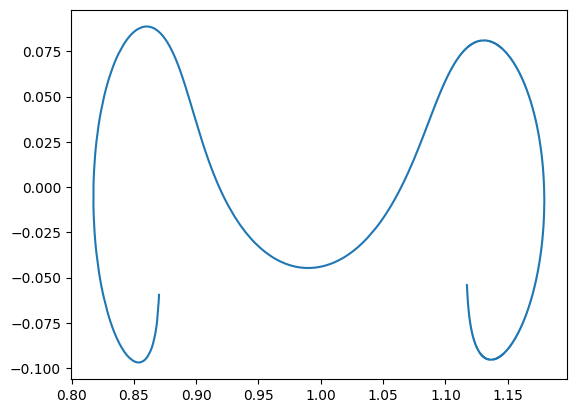

In [66]:
plt.plot(trajectory[:, 0], trajectory[:, 1])

In [67]:
# three body problem env
class ThreeBodyEnv(gym.Env):
    def __init__(self, trajectory_, error_range=0.1, final_range=0.1):
        self.trajectory = trajectory_
        self.state = np.zeros(4)
        self.dt = 0.001
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-4, high=4, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory_[0]
        self.steps = 0
        self.max_steps = 6000
        self.final_range = final_range
        self.error_range = error_range
        self.reward_range = (-float('inf'), float('inf'))
        self.render_logic = False
        # second player
        self.second_player = True
        self.reset()

    def step(self, action, action_2):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        # force = action[0] * env.state[2:] + action[1] * env.state[:2]
        a_x = action[0] / 100
        a_y = action[1] / 100
        # add second player action
        a_x_2 = action_2[0] / 200 if self.second_player else 0
        a_y_2 = action_2[1] / 200 if self.second_player else 0

        r1 = np.sqrt((x + self.mu) ** 2 + y ** 2)
        r2 = np.sqrt((x - 1 + self.mu) ** 2 + y ** 2)

        xddot = 2 * ydot + x - (1 - self.mu) * ((x + self.mu) / (r1 ** 3)) - self.mu * (x - 1 + self.mu) / (
                    r2 ** 3) + a_x + a_x_2
        yddot = -2 * xdot + y - (1 - self.mu) * (y / (r1 ** 3)) - self.mu * y / (r2 ** 3) + a_y + a_y_2

        x = x + xdot * self.dt
        y = y + ydot * self.dt

        xdot = xdot + xddot * self.dt
        ydot = ydot + yddot * self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        # plot position
        if self.render_logic:
            plt.plot(x, y, 'ro')
            plt.plot(self.trajectory[:, 0], self.trajectory[:, 1])
            plt.show()

        distance = np.linalg.norm(self.trajectory[:, 0:2] - self.position[0:2],
                                  axis=1)  # just add position and delete velocity
        nearest_idx = np.argmin(distance)
        reward = 100 * (
                    1 - np.linalg.norm(self.state, axis=0) - (a_x / 10) ** 2 - (a_y / 10) ** 2 + (a_x_2 / 10) ** 2 + (
                        a_y_2 / 10) ** 2) - 100
        done = self.steps >= self.max_steps
        states_array.append(self.state)
        if np.linalg.norm(self.position[0:2] - self.trajectory[-1, 0:2]) < self.final_range:
            done = True
            reward = 1000
            print(colorize("done 🥺", 'green', bold=True))
            if self.second_player:
                print(colorize("second player was in the game", 'blue'))
        if self.steps > 20000:
            done = True
            reward = -1000
            print("end time")
            if self.second_player:
                print(colorize("second player was in the game", 'blue'))
        if self.error_calculation() > self.error_range:
            print(self.state)
            done = True
            reward = -1000 + (nearest_idx / 10000) * 1000
            print('idx', nearest_idx / 100000, 'state', np.linalg.norm(self.state, axis=0))
            print(colorize("too much error 🥲😱", 'red', bold=True))
            if self.second_player:
                print(colorize("second player was in the game", 'blue'))

        # print(self.state, reward, done, self.position)
        return 1000 * self.state, reward, done, False, self.position

    def position2state(self):
        # find the nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory[:, 0:2] - self.position[0:2],
                                  axis=1)  # just add position and delete velocity
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
        # self.state = self.state * np.array([10, 10, 1, 1])

    def error_calculation(self):
        normalized_error = self.state * np.array([1, 1, 0.0, 0.0])  # reduce the effect of velocity error
        return np.linalg.norm(normalized_error)

    def reset(self,
              *,
              seed: 5 = None,
              return_info: bool = False,
              options: 6 = None):
        self.position = self.trajectory[0]
        self.steps = 0
        self.position2state()
        return 1000 * self.state, {}

In [68]:
# Define variables directly
env = ThreeBodyEnv(trajectory)
hid = 32
l = 2
gamma = 0.99
seed = 0
epochs = 50
exp_name = 'ddpg'
steps_per_epoch_ = 30000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ac_kwargs = dict(hidden_sizes=[hid] * l)
states_array = []
logger_kwargs = setup_logger_kwargs(exp_name, seed)
reward_array = []
ddpg = DG_DDPG(lambda: ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), MLPActorCritic, ac_kwargs,
               seed_=seed, steps_per_epoch=steps_per_epoch_, epochs_=epochs, logger_kwargs_=logger_kwargs,
               device=device, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000, first_player_epoch=50)

Logging data to /Users/Ali/Documents/BAI/Master/master-thesis/Code/Python/TBP/DDPG/DG/data/ddpg/ddpg_s0/progress.txt
Saving config:

{
    "ac_kwargs_":	{
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "act_dim":	2,
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	1024,
    "device":	"cpu",
    "env_fn":	"<function <lambda> at 0x16335f560>",
    "epochs_":	50,
    "exp_name":	"ddpg",
    "first_player_epoch":	50,
    "gamma_":	0.99,
    "logger_kwargs_":	{
        "exp_name":	"ddpg",
        "output_dir":	"/Users/Ali/Documents/BAI/Master/master-thesis/Code/Python/TBP/DDPG/DG/data/ddpg/ddpg_s0"
    },
    "max_ep_len":	6000,
    "num_test_episodes":	10,
    "obs_dim":	[
        4
    ],
    "p":	"Parameter containing:\ntensor([0.1690])",
    "pi_lr":	0.001,
    "polyak":	0.995,
    "q_lr":	0.001,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed_":	0,
    "self":	{
        "<__main__.DG_DDPG object at 0x163351650>":	{
 

In [69]:
ddpg.load(from_device_to_load='cuda')

Model loaded successfully and device is cpu! 🥰😎


In [70]:
# print(ddpg.ac.pi)
# dot = torchviz.make_dot(ddpg.ac.pi(torch.randn(1, ddpg.obs_dim[0], device=device)), params=dict(ddpg.ac.pi.named_parameters()), show_attrs=True)
# dot.graph_attr.update(size="10,10")
# dot

In [71]:
ddpg.env.second_player = True

done 🥺
second player was in the game
(9999, 6)


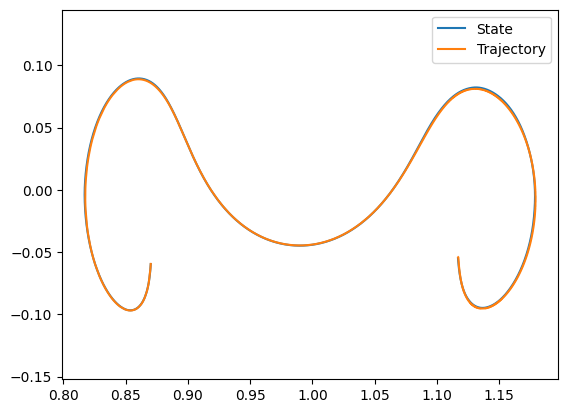

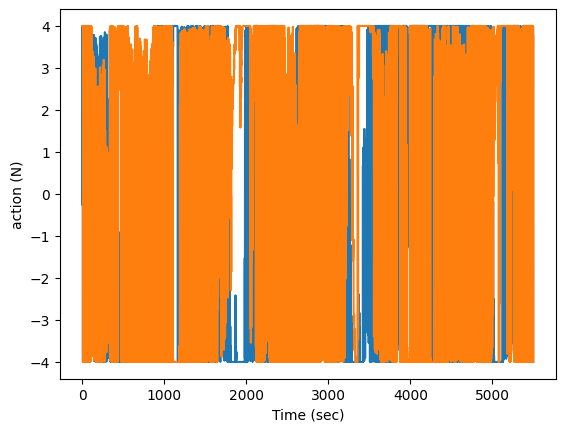

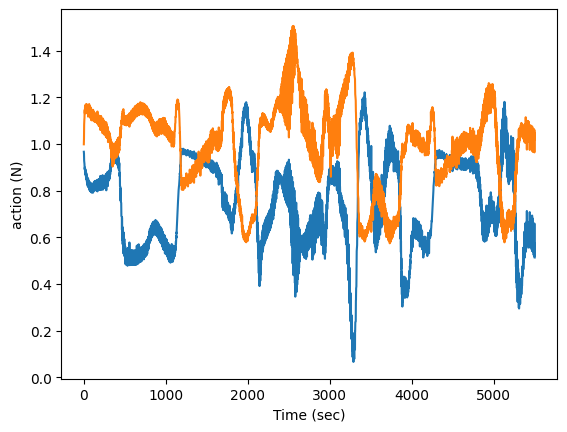

In [72]:
ddpg.test()

In [73]:
# print(reward_array)

In [74]:
# rewards = np.array(reward_array)

In [75]:
# rewards_ = rewards[(rewards != 1000) & (rewards > -10)]
# plt.plot(rewards_)

updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
Epoch 1 completed in 45.49 sec
---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |            -377 |
|          StdEpRet |             401 |
|          MaxEpRet |             220 |
|          MinEpRet |            -869 |
|             EpLen |         5.5e+03 |
| TotalEnvInteracts |           3e+04 |
|    AverageQVals_2 |            6.62 |
|        StdQVals_2 |            5.55 |
|        MaxQVals_2 |            23.4 |
|        MinQVals_2 |           -22.8 |
|          LossPi_2 |   

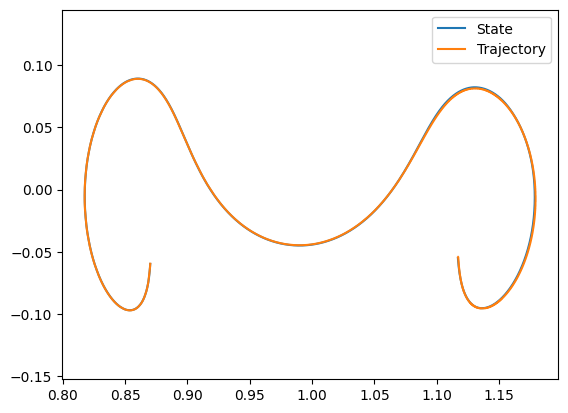

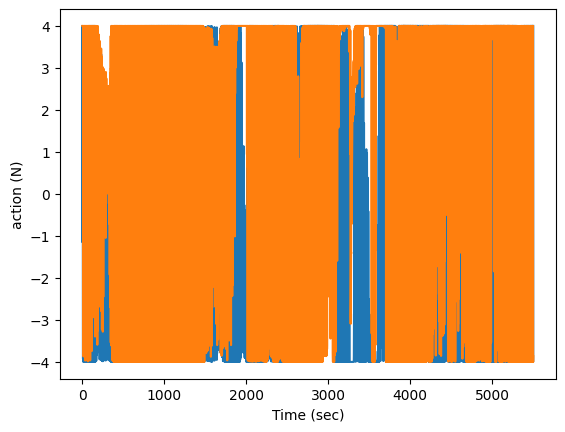

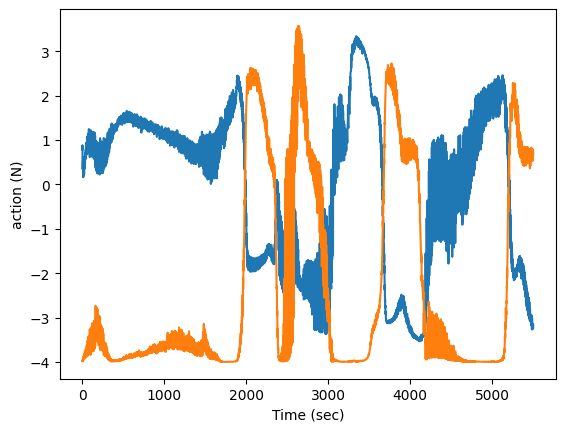

done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
Epoch 2 completed in 100.29 sec
---------------------------------------
|             Epoch |               2 |
|      AverageEpRet |            -191 |
|          StdEpRet |             447 |
|          MaxEpRet |             781 |
|          MinEpRet |            -559 |
|             EpLen |           5e+03 |
| TotalEnvInteracts |           6e+04 |
|    AverageQVals_2 |            19.1 |
|        StdQVals_2 |            7.39 |
|        MaxQVals_2 |              36 |
|     

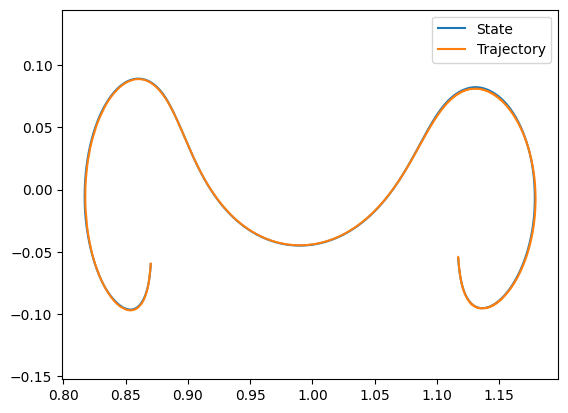

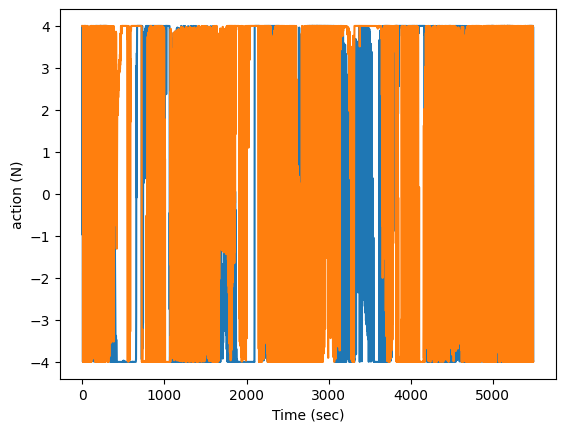

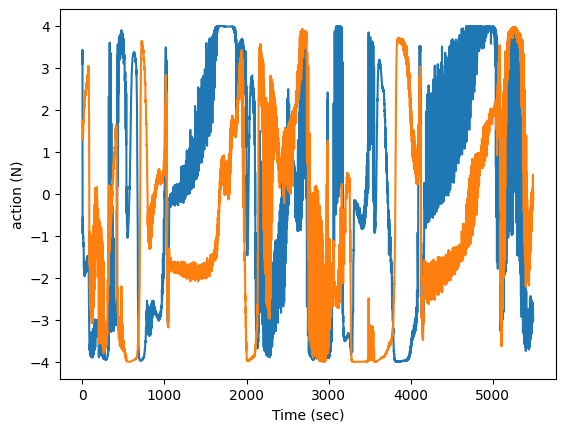

done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️
updating second 🥰☺️
done 🥺
second player was in the game
updating second 🥰☺️
updating second 🥰☺️


KeyboardInterrupt: 

In [76]:
ddpg.train(epochs_=500)
# states = np.array(states_array)
# # separate figure for each state
# for i in range(states.shape[1]):
#     plt.plot(states[:,i])
#     plt.show()


done 🥺
second player was in the game
(9999, 6)


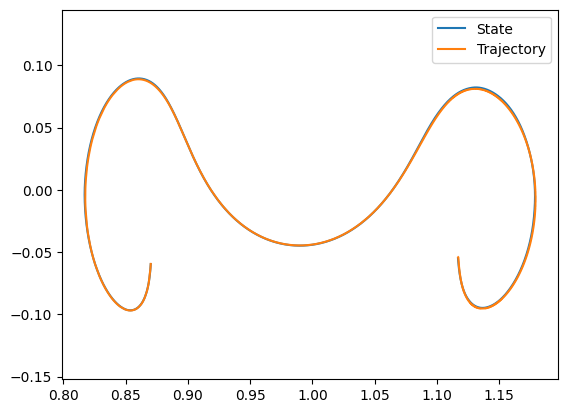

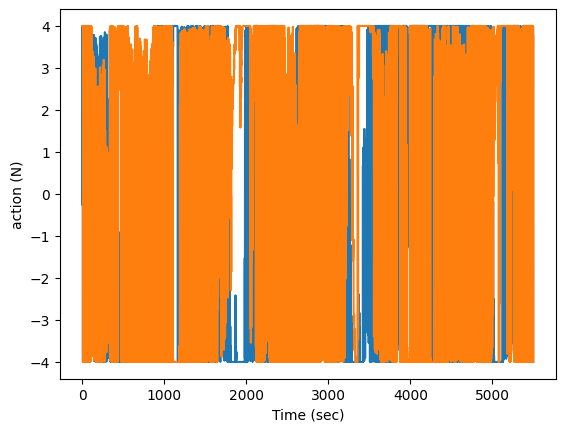

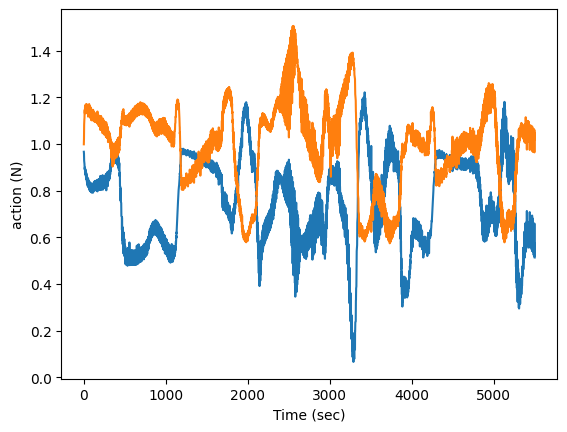

In [81]:
ddpg.test()

In [78]:
# ddpg.save()

ddpg.save_2()

In [83]:
if True:
    try:
        # noinspection PyUnresolvedReferences
        import google.colab

        # download created models
        if os.path.isfile("DDPG_TBP_results.tar.gz"):
            os.remove("DDPG_TBP_results.tar.gz")
        !tar cvfz DDPG_TBP_results.tar.gz model/
        # noinspection PyUnresolvedReferences
        from google.colab import files

        files.download('DDPG_TBP_results.tar.gz')
        print(colorize("Done! 🥰😎", 'blue', bold=True))
    except Exception as e:
        print(e, end=' ----> ')
        print(colorize("Something Wrong 🧐😩, or maybe you used your Mac 😱🥲", 'red', bold=True))
else:
    print(colorize("You are in test mode! 🥰😎", 'blue', bold=True))

No module named 'google.colab' ----> Something Wrong 🧐😩, or maybe you used your Mac 😱🥲
